In [1]:
import copy
import json
import numpy as np
import matplotlib.pyplot as plt

from utils import ConfigObject
from utils import reserve_pop
from utils import id_generator
from utils import writer
from utils import LibriSpeechGenerator

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
import torch.nn.functional as F

from parts import VSConvBlock
from parts import DownSamplingBlock
from parts import UpSamplingBlock
from parts import OutBlock

In [2]:
import time

## Parameters

In [3]:
jsonConfig = {
    "test_platform": False,
    "ds_prop": 0.25,
    "sr": 16000,
    "n_samples": 65536,
    
    "n_channels": 1,
    "n_classes": 1,
    "depth": 5,
    "fsize": 24,
    "moffset": 8,
    
    "batch_size": 16,
    "epochs": 25,
    "shuffle": True,
    "num_workers": 8,
    "verbose": 100,

    "checkpoint_path": "../models/model_checkpoint.pt",
    "model_path": "../models/last_model.pt",

    "save_last_batch": True,
    "writer_path": "../logs/",
    "history_path": "../logs/history.json"
}

config = ConfigObject(**jsonConfig)

In [4]:
# Data Loaders
_params = {
    'batch_size': config.batch_size,
    'shuffle': config.shuffle,
    'num_workers': config.num_workers
}

## Import Data

In [5]:
X_train = torch.load("../data/processed/noisy/train/x_train.pt")
y_train = torch.load("../data/processed/noisy/train/y_train.pt")
X_val = torch.load("../data/processed/noisy/val/x_val.pt")
y_val = torch.load("../data/processed/noisy/val/y_val.pt")

## Data Generators

In [6]:
# Data Generators
lsg = LibriSpeechGenerator(config, X_train, y_train)
lsg_val = LibriSpeechGenerator(config, X_val, y_val)

ls_generator = data.DataLoader(lsg, **_params)
ls_val_generator = data.DataLoader(lsg_val, **_params)

## Model

In [7]:
class SEWUNet(nn.Module):
    def __init__(self, config, fd=15, fu=5):
        """Speech Enhancenment using Wave-U-Net"""
        super(SEWUNet, self).__init__()

        # Hyperparameters
        self.n_channels = config.n_channels
        self.n_classes = config.n_classes
        self.depth = config.depth
        self.fsize = config.fsize
        self.moffset = config.moffset
        self.fd = fd
        self.fu = fu

        # Generate the list of in, out channels for the encoder
        self.enc_filters = [self.n_channels]
        self.enc_filters += [self.fsize * i + self.moffset
                             for i in range(1, self.depth + 1)]
        self.n_encoder = zip(self.enc_filters, self.enc_filters[1:])

        # Bottleneck block sizes
        mid_in = self.fsize * self.depth + self.moffset
        mid_out = self.fsize * (self.depth + 1) + self.moffset

        # Generate the list of in, out channels for the decoder
        self.out_dec = reserve_pop(self.enc_filters)
        self.in_dec = [mid_out + self.enc_filters[-1]]
        self.in_dec += [self.out_dec[i] + self.out_dec[i + 1]
                        for i in range(self.depth - 1)]
        self.n_decoder = zip(self.in_dec, self.out_dec)

        # Architecture and parameters
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()

        # Build the encoder part of the U-net architecture
        for i, (in_ch, out_ch) in enumerate(self.n_encoder):
            self.encoder.append(DownSamplingBlock(
                in_ch=in_ch,
                out_ch=out_ch,
                kernel_size=self.fd,
                padding=self.fd // 2,
                activation=nn.LeakyReLU(0.1))
            )

        # Bottleneck block for the U-net
        self.mid_block = VSConvBlock(
            in_ch=mid_in,
            out_ch=mid_out,
            kernel_size=self.fd,
            padding=self.fd // 2,
            activation=nn.LeakyReLU(0.1))

        # Build the decoder part of the U-net architecture
        for in_ch, out_ch in self.n_decoder:
            self.decoder.append(UpSamplingBlock(
                in_ch=in_ch,
                out_ch=out_ch,
                kernel_size=self.fu,
                padding=self.fu // 2,
                activation=nn.LeakyReLU(0.1))
            )

        # Output block
        out_ch = self.out_dec[-1] + 1
        self.out_block = OutBlock(
            in_ch=out_ch,
            out_ch=self.n_classes,
            activation=nn.Tanh()
        )

    def forward(self, x):
        """"""
        enc = []
        net_in = copy.copy(x)

        for i in range(self.depth):
            x, xi = self.encoder[i](x)
            enc.append(xi)

        x = self.mid_block(x)

        for i in range(self.depth):
            x = self.decoder[i](x, enc.pop())

        x = self.out_block(x, net_in)

        return x

## Trainer

In [8]:
model = SEWUNet(config)

In [9]:
# Training parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
history = {'loss': [], 'SNR': [], 'val_loss': [], 'val_SNR': []}

In [10]:
def CustomMetric():
    """Calculate the SNR of X and Y"""
    def SNR(X, Y):
        n = X.shape[2]
        return torch.mean(10 * torch.log10(
            (torch.norm(Y, dim=2)**2 / n) /
            (torch.norm(X - Y, dim=2)**2 / n)
        ))
    return SNR

In [11]:
# Build optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-6,
    betas=(0.9, 0.999))

# lr_scheduler = torch.optim.lr_scheduler(optimizer)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

# Loss and metric
m_loss = nn.L1Loss()
m_snr = CustomMetric()

# Print validation metric before trainer
print("SNR (Validation): {}".format(m_snr(lsg_val.X, lsg_val.y).item()))

SNR (Validation): 10.05069351196289


In [12]:
# Copy model to device
model = model.to(device)

In [13]:
# Calculate the number of trainable parameters in the model
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
sum([np.prod(p.size()) for p in model_parameters])

1139372

In [14]:
# Function to display trainning metrics
def _display_metrics(epoch, it, steps, loss, metric):
    print("Epoch [{:02d}/{:02d}]".format(
        epoch + 1, config.epochs), end=", ")

    print("Step [{:03d}/{:03d}]".format(
        it + 1, steps), end=", ")

    print("Loss: {}, SNR: {}".format(
        loss, metric))

In [15]:
# Train the model over epochs
steps = len(ls_generator)
start_time = time.time()

for epoch in range(config.epochs):
    # training and val metrics for all data
    loss, metric = 0.0, 0.0
    val_loss, val_metric = 0.0, 0.0

    # ======================== Training ============================= #
    for i, (local_batch, local_labels) in enumerate(ls_generator):
        # Transfer to Device
        local_batch = local_batch.to(device)
        local_labels = local_labels.to(device)

        # Set gradient
        optimizer.zero_grad()

        # Forward pass, backward pass, optimize
        outputs = model(local_batch)
        loss_batch = m_loss(outputs, local_labels)
        batch_metric = m_snr(outputs, local_labels)
        loss_batch.backward()
        optimizer.step()

        # Compute metrics to all batch
        loss += loss_batch.item() * len(local_batch)
        metric += batch_metric.item() * len(local_batch)

        # Print the loss every "verbose" batches
        if (i + 1) % config.verbose == 0:
            _display_metrics(epoch, i, steps,
                loss_batch.item(), batch_metric.item())

    # Compute the statistics of the last epoch and save to history
    history['loss'].append(loss / len(lsg))
    history['SNR'].append(metric / len(lsg))

    # Checkpoint the model
    torch.save(model.state_dict(), config.checkpoint_path)
    
    # Print Validation statistics
    print(".:. Training metrics =", end=" ")
    print("Loss: {}, SNR: {}".format(loss / len(lsg), metric / len(lsg)))
    
    # ======================= Validation ============================ #
    with torch.no_grad():
        for local_batch, local_labels in ls_val_generator:
            # Transfer to device
            local_batch = local_batch.to(device)
            local_labels = local_labels.to(device)

            # Predict, get loss and metric
            outputs = model(local_batch)
            val_loss += m_loss(outputs, local_labels).item() \
                * len(local_batch)

            val_metric += m_snr(outputs, local_labels).item() \
                * len(local_batch)

        val_loss /= len(lsg_val)
        val_metric /= len(lsg_val)
                
    # Print Validation statistics
    print(".:. Validation metrics =", end=" ")
    print("Loss: {}, SNR: {}".format(val_loss, val_metric))

    # Compute the metrics and loss of last batch and save to history
    history['val_loss'].append(val_loss)
    history['val_SNR'].append(val_metric)
    lr_scheduler.step(val_loss)

elapsed_time = time.time() - start_time
history['elapsed_time'] = elapsed_time

Epoch [01/25], Step [100/1803], Loss: 0.04428306594491005, SNR: -2.4753310680389404
Epoch [01/25], Step [200/1803], Loss: 0.034397199749946594, SNR: 1.3119312524795532
Epoch [01/25], Step [300/1803], Loss: 0.025615144520998, SNR: 3.9518463611602783
Epoch [01/25], Step [400/1803], Loss: 0.020957859233021736, SNR: 4.828291416168213
Epoch [01/25], Step [500/1803], Loss: 0.019809134304523468, SNR: 5.383466720581055
Epoch [01/25], Step [600/1803], Loss: 0.018589459359645844, SNR: 5.510369300842285
Epoch [01/25], Step [700/1803], Loss: 0.018613435328006744, SNR: 6.368080139160156
Epoch [01/25], Step [800/1803], Loss: 0.015867672860622406, SNR: 6.935920715332031
Epoch [01/25], Step [900/1803], Loss: 0.015716083347797394, SNR: 6.467394828796387
Epoch [01/25], Step [1000/1803], Loss: 0.01548947673290968, SNR: 7.03093957901001
Epoch [01/25], Step [1100/1803], Loss: 0.013291444629430771, SNR: 9.063199043273926
Epoch [01/25], Step [1200/1803], Loss: 0.02539989724755287, SNR: 7.106131553649902
Epoc

.:. Validation metrics = Loss: 0.008371790282820401, SNR: 13.350174196117676
Epoch [06/25], Step [100/1803], Loss: 0.009224780835211277, SNR: 12.15718936920166
Epoch [06/25], Step [200/1803], Loss: 0.012171165086328983, SNR: 11.868850708007812
Epoch [06/25], Step [300/1803], Loss: 0.007633144035935402, SNR: 13.677124977111816
Epoch [06/25], Step [400/1803], Loss: 0.0076002017594873905, SNR: 13.16380500793457
Epoch [06/25], Step [500/1803], Loss: 0.006863073445856571, SNR: 13.583941459655762
Epoch [06/25], Step [600/1803], Loss: 0.012539981864392757, SNR: 11.240049362182617
Epoch [06/25], Step [700/1803], Loss: 0.009719420224428177, SNR: 12.21314811706543
Epoch [06/25], Step [800/1803], Loss: 0.008010799996554852, SNR: 14.272464752197266
Epoch [06/25], Step [900/1803], Loss: 0.011484164744615555, SNR: 12.89985466003418
Epoch [06/25], Step [1000/1803], Loss: 0.00862180907279253, SNR: 13.251618385314941
Epoch [06/25], Step [1100/1803], Loss: 0.006604962050914764, SNR: 13.54355239868164
Ep

.:. Training metrics = Loss: 0.008063677168270113, SNR: 13.862511455890784
.:. Validation metrics = Loss: 0.007424662694141872, SNR: 14.075312879532616
Epoch [11/25], Step [100/1803], Loss: 0.007255478762090206, SNR: 13.703855514526367
Epoch [11/25], Step [200/1803], Loss: 0.007444534916430712, SNR: 14.320298194885254
Epoch [11/25], Step [300/1803], Loss: 0.0077450755052268505, SNR: 13.525017738342285
Epoch [11/25], Step [400/1803], Loss: 0.007131774909794331, SNR: 14.3926420211792
Epoch [11/25], Step [500/1803], Loss: 0.008541376329958439, SNR: 13.28829574584961
Epoch [11/25], Step [600/1803], Loss: 0.0077815307304263115, SNR: 13.812055587768555
Epoch [11/25], Step [700/1803], Loss: 0.008790146559476852, SNR: 13.666913986206055
Epoch [11/25], Step [800/1803], Loss: 0.008046318776905537, SNR: 13.962971687316895
Epoch [11/25], Step [900/1803], Loss: 0.007004409097135067, SNR: 13.739261627197266
Epoch [11/25], Step [1000/1803], Loss: 0.009479578584432602, SNR: 13.467211723327637
Epoch [1

Epoch [15/25], Step [1800/1803], Loss: 0.006645298562943935, SNR: 14.492193222045898
.:. Training metrics = Loss: 0.0076171674987117735, SNR: 14.353958064505576
.:. Validation metrics = Loss: 0.007073291915960765, SNR: 14.647758429405457
Epoch [16/25], Step [100/1803], Loss: 0.007100443355739117, SNR: 14.550176620483398
Epoch [16/25], Step [200/1803], Loss: 0.009477062150835991, SNR: 13.616886138916016
Epoch [16/25], Step [300/1803], Loss: 0.008549200370907784, SNR: 14.241193771362305
Epoch [16/25], Step [400/1803], Loss: 0.008612385019659996, SNR: 15.144351959228516
Epoch [16/25], Step [500/1803], Loss: 0.006178450305014849, SNR: 14.192558288574219
Epoch [16/25], Step [600/1803], Loss: 0.006536804139614105, SNR: 14.490084648132324
Epoch [16/25], Step [700/1803], Loss: 0.007985995151102543, SNR: 14.81401252746582
Epoch [16/25], Step [800/1803], Loss: 0.006818071007728577, SNR: 15.161272048950195
Epoch [16/25], Step [900/1803], Loss: 0.009024582803249359, SNR: 13.976608276367188
Epoch [

Epoch [20/25], Step [1700/1803], Loss: 0.00654595298692584, SNR: 15.005887985229492
Epoch [20/25], Step [1800/1803], Loss: 0.00725255161523819, SNR: 16.151918411254883
.:. Training metrics = Loss: 0.007339780676939187, SNR: 14.683017405546291
.:. Validation metrics = Loss: 0.0068998650323301046, SNR: 14.915724217339944
Epoch [21/25], Step [100/1803], Loss: 0.007073031738400459, SNR: 14.040371894836426
Epoch [21/25], Step [200/1803], Loss: 0.007418198045343161, SNR: 14.728482246398926
Epoch [21/25], Step [300/1803], Loss: 0.009418309666216373, SNR: 13.526447296142578
Epoch [21/25], Step [400/1803], Loss: 0.008951650001108646, SNR: 15.065353393554688
Epoch [21/25], Step [500/1803], Loss: 0.006549696438014507, SNR: 14.781513214111328
Epoch [21/25], Step [600/1803], Loss: 0.007419083267450333, SNR: 14.15644359588623
Epoch [21/25], Step [700/1803], Loss: 0.007271800190210342, SNR: 15.082571029663086
Epoch [21/25], Step [800/1803], Loss: 0.00723081873729825, SNR: 14.593706130981445
Epoch [21

Epoch [25/25], Step [1600/1803], Loss: 0.006380870938301086, SNR: 14.720996856689453
Epoch [25/25], Step [1700/1803], Loss: 0.006205449812114239, SNR: 15.471891403198242
Epoch [25/25], Step [1800/1803], Loss: 0.006124178878962994, SNR: 15.853748321533203
.:. Training metrics = Loss: 0.0071372523416338655, SNR: 14.93141395580488
.:. Validation metrics = Loss: 0.0068875416424603285, SNR: 14.810803748602213


In [16]:
# Save the last model
torch.save(model.state_dict(), config.model_path)

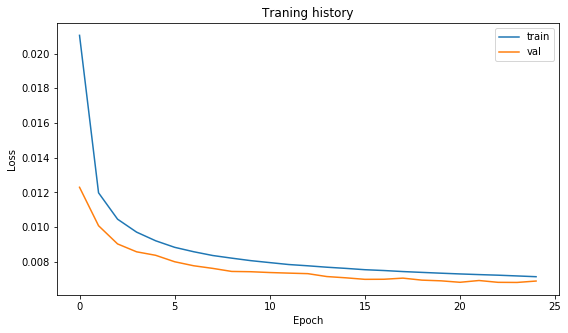

In [17]:
# Plot network history
plt.figure(figsize=(9,5))
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Traning history')
plt.legend()
plt.show()

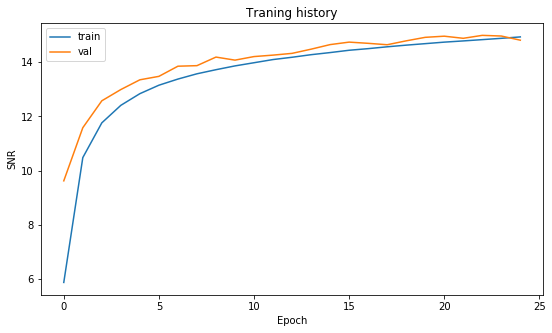

In [18]:
# Plot network history
plt.figure(figsize=(9,5))
plt.plot(history['SNR'], label='train')
plt.plot(history['val_SNR'], label='val')
plt.ylabel('SNR')
plt.xlabel('Epoch')
plt.title('Traning history')
plt.legend()
plt.show()

In [19]:
# Save history to a JSON file
with open(config.history_path, 'w') as fp:
    json.dump(history, fp)

## Test

In [20]:
X_test = torch.load("../data/processed/noisy/test/x_test.pt")
y_test = torch.load("../data/processed/noisy/test/y_test.pt")

In [21]:
print(X_test.shape)

torch.Size([3874, 1, 65536])


In [22]:
_params = {
    'batch_size': config.batch_size,
    'shuffle': False,
    'num_workers': config.num_workers
}

lsg_test = LibriSpeechGenerator(config, X_test, y_test)
ls_test_generator = data.DataLoader(lsg_test, **_params)

In [23]:
X_test.shape

torch.Size([3874, 1, 65536])

In [24]:
# Print validation metric before trainer
print("SNR (Test): {}".format(m_snr(lsg_test.X, lsg_test.y).item()))

SNR (Test): 10.058753967285156


In [25]:
test_loss, test_metric = 0.0, 0.0
with torch.no_grad():
    for local_batch, local_labels in ls_test_generator:
        # Transfer to device
        local_batch = local_batch.to(device)
        local_labels = local_labels.to(device)

        # Predict, get loss and metric
        outputs = model(local_batch)
        test_loss += m_loss(outputs, local_labels).item() \
            * len(local_batch)

        test_metric += m_snr(outputs, local_labels).item() \
            * len(local_batch)
        
        writer(local_batch, local_labels,
               outputs, config.sr, config.writer_path)

    test_loss /= len(lsg_test)
    test_metric /= len(lsg_test)

In [26]:
import os

test_history = {
    'SNR_ini': m_snr(lsg_test.X, lsg_test.y).item(),
    'SNR': test_metric, 
    'loss': test_loss
}

with open(os.path.join(config.writer_path, 'test_history.json') , 'w') as fp:
    json.dump(test_history, fp)